In [13]:
import time
# Medir el tiempo de inicio
start_time = time.time()

In [14]:
!pip install category_encoders
!pip install optuna

# Imports

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split  # Importar train_test_split para dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.preprocessing import StandardScaler, LabelEncoder  # Importar StandardScaler para escalar características y LabelEncoder para codificar etiquetas objetivo
from sklearn.svm import SVC  # Importar SVC para clasificador de vectores de soporte
from sklearn import metrics  # Importar métricas de sklearn para evaluación del modelo
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score  # Importar métricas específicas para evaluación del modelo
import warnings  # Importar warnings para gestionar advertencias
import category_encoders as ce  # Importar category_encoders para codificar características categóricas
import optuna
# Ignorar advertencias
warnings.filterwarnings('ignore')  # Suprimir advertencias para una salida más limpia

# Code

In [16]:
# URL raw del archivo CSV en GitHub
url = 'https://raw.githubusercontent.com/Meusz/FinOps/main/data/Cancer_Data.csv'

# Leer el archivo CSV desde la URL
df = pd.read_csv(url)

# Establecer opción para mostrar todas las columnas
pd.set_option('display.max_columns', None)

# Mostrar el DataFrame para ver los datos cargados
df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


In [17]:
df_copy = df.copy()

Antes de continuar con el análisis de datos, realizaremos algunas operaciones de preprocesamiento en el DataFrame.

Vamos a eliminar las columnas 'Unnamed: 32' e 'id' del DataFrame, ya que no contienen información relevante para nuestro análisis.

In [18]:
# Eliminar las columnas 'Unnamed: 32' e 'id' del DataFrame
df_copy.drop(['Unnamed: 32', 'id'], axis=1, inplace=True)

# Mapear los valores de la columna 'diagnosis' de 'B' y 'M' a 0 y 1 respectivamente
df_copy['diagnosis'] = df_copy['diagnosis'].map({'B': 0, 'M': 1})

# Iterar sobre cada columna en el DataFrame
for col in df_copy.columns:
    # Verificar si el tipo de datos de la columna es numérico (int64 o float64)
    if df_copy[col].dtype in ['int64', 'float64']:
        # Rellenar los valores faltantes con la media de la columna
        df_copy[col] = df_copy[col].fillna(df_copy[col].mean())
    # Verificar si el tipo de datos de la columna es objeto (categórico)
    elif df_copy[col].dtype == 'object':
        # Rellenar los valores faltantes con la moda (valor más frecuente) de la columna
        df_copy[col] = df_copy[col].fillna(df_copy[col].mode().iloc[0])

# Eliminar filas duplicadas del DataFrame
df_copy.drop_duplicates(inplace=True)

In [19]:
# Asignar la columna 'diagnosis' como la variable objetivo
objetivos = df_copy['diagnosis']

# Crear entradas eliminando la columna 'diagnosis' del DataFrame
entradas = df_copy.drop('diagnosis', axis=1)

# Importar las bibliotecas necesarias
from sklearn.model_selection import train_test_split

# Dividir los datos en conjuntos de entrenamiento y prueba
x_entrenamiento, x_prueba, y_entrenamiento, y_prueba = train_test_split(entradas, objetivos, test_size=0.2, random_state=42)

In [20]:
# Definir el modelo SVC con la estimación de probabilidad habilitada
svc_model_def = SVC(probability=True)

In [21]:
def train_and_evaluate_model(model_name, model, X_train, y_train, X_test, y_test):
    """
    Entrena y evalúa el modelo dado en los datos de entrenamiento y prueba.

    Parámetros:
    model_name (str): Nombre del modelo para fines de visualización.
    model : Objeto del modelo de aprendizaje automático.
    X_train : Características de los datos de entrenamiento.
    y_train : Etiquetas objetivo de los datos de entrenamiento.
    X_test : Características de los datos de prueba.
    y_test : Etiquetas objetivo de los datos de prueba.

    Devoluciones:
    float, float: Coeficientes Gini calculados a partir de las predicciones del modelo en datos de entrenamiento y prueba.
    """

    # Ajustar el modelo en los datos de entrenamiento
    model.fit(X_train, y_train)

    # Predecir etiquetas y probabilidades en los datos de prueba
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)[:, 1]

    # Predecir etiquetas y probabilidades en los datos de entrenamiento
    y_train_pred = model.predict(X_train)
    y_train_prob = model.predict_proba(X_train)[:, 1]

    # Calcular ROC AUC y coeficiente Gini para datos de prueba
    roc_test_prob = roc_auc_score(y_test, y_test_prob)
    gini_test_prob = roc_test_prob * 2 - 1

    # Calcular ROC AUC y coeficiente Gini para datos de entrenamiento
    roc_train_prob = roc_auc_score(y_train, y_train_prob)
    gini_train_prob = roc_train_prob * 2 - 1

    # Calcular la matriz de confusión y el informe de clasificación para los datos de prueba
    confusion_matrix_test_result = confusion_matrix(y_test, y_test_pred)
    classification_report_test_result = classification_report(y_test, y_test_pred)

    # Calcular la matriz de confusión y el informe de clasificación para los datos de entrenamiento
    confusion_matrix_train_result = confusion_matrix(y_train, y_train_pred)
    classification_report_train_result = classification_report(y_train, y_train_pred)

    # Imprimir métricas de rendimiento del modelo
    print(f'Rendimiento del modelo para {model_name}')
    print('Gini prob para datos de prueba es', gini_test_prob * 100)
    print('Gini prob para datos de entrenamiento es', gini_train_prob * 100)
    print('Informe de clasificación para los Datos de Prueba:')
    print(classification_report_test_result)
    print('Matriz de Confusión para los Datos de Prueba:')
    print(confusion_matrix_test_result)
    print('Informe de clasificación para los Datos de Entrenamiento:')
    print(classification_report_train_result)
    print('Matriz de Confusión para los Datos de Entrenamiento:')
    print(confusion_matrix_train_result)

    return gini_train_prob, gini_test_prob

# Suponiendo que svc_model_def, x_train, y_train, x_test, y_test están definidos
gini_df = pd.DataFrame(columns=['Modelo', 'Gini_train_prob', 'Gini_test_prob'])
gini_train_prob, gini_test_prob = train_and_evaluate_model('svc', svc_model_def, x_train, y_train, x_test, y_test)

# Agregar el resultado al DataFrame usando concat y ordenarlo
new_row = pd.DataFrame([{'Modelo': 'svc', 'Gini_train_prob': gini_train_prob, 'Gini_test_prob': gini_test_prob}])
gini_df = pd.concat([gini_df, new_row], ignore_index=True)
gini_df_sorted = gini_df.sort_values(by='Gini_test_prob', ascending=False)

print(gini_df_sorted)


Model Performance for svc
Gini prob for testing data is 98.68981329839501
Gini prob for training data is 93.97525551371709
Classification Report for Testing Data:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        71
           1       1.00      0.86      0.92        43

    accuracy                           0.95       114
   macro avg       0.96      0.93      0.94       114
weighted avg       0.95      0.95      0.95       114

Confusion Matrix for Testing Data:
[[71  0]
 [ 6 37]]
Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.89      0.98      0.94       286
           1       0.96      0.80      0.87       169

    accuracy                           0.91       455
   macro avg       0.93      0.89      0.90       455
weighted avg       0.92      0.91      0.91       455

Confusion Matrix for Training Data:
[[281   5]
 [ 34 135]]
  Model  Gini_train_prob  Gin

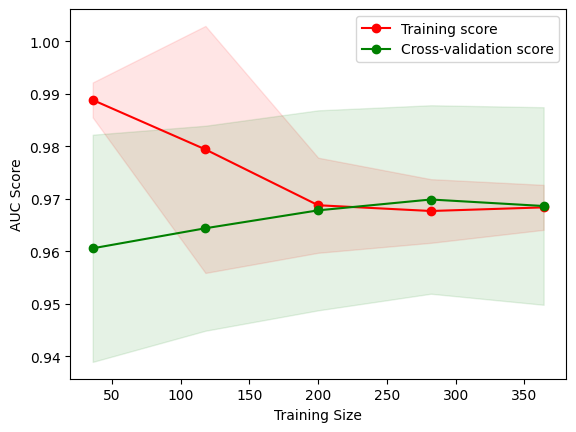

In [22]:
# Importar las bibliotecas necesarias
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Generar curvas de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(svc_model_def, x_train, y_train, cv=5, scoring='roc_auc')

# Calcular la media y la desviación estándar de los puntajes de entrenamiento y validación cruzada
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Graficar las curvas de aprendizaje
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Puntaje de Entrenamiento')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Puntaje de Validación Cruzada')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')
plt.xlabel('Tamaño de Entrenamiento')
plt.ylabel('Puntuación AUC')
plt.legend(loc='best')
plt.show()


In [23]:
# Medir el tiempo de finalización
end_time = time.time()
# Calcular y mostrar el tiempo de ejecución
execution_time = end_time - start_time
print(f'Tiempo de ejecución: {execution_time:.2f} segundos')

Tiempo de ejecución: 32.06 segundos


In [24]:
import os
import psutil
import subprocess

# Obtener información del procesador
cpu_info = os.popen("cat /proc/cpuinfo | grep 'model name' | uniq").read().strip()
print(f'Modelo de procesador: {cpu_info}')

# Número de procesadores físicos
num_processors = psutil.cpu_count(logical=False)
print(f'Número de procesadores físicos: {num_processors}')

# Número de vCores
num_vcores = psutil.cpu_count(logical=True)
print(f'Número de vCores (procesadores lógicos): {num_vcores}')

# Capacidad de memoria
mem = psutil.virtual_memory()
total_memory_gb = mem.total / (1024 ** 3)  # Convertir bytes a GB
available_memory_gb = mem.available / (1024 ** 3)  # Convertir bytes a GB
print(f'Capacidad total de memoria RAM: {total_memory_gb:.2f} GB')
print(f'Memoria RAM disponible: {available_memory_gb:.2f} GB')

# Información del disco duro
disk_usage = psutil.disk_usage('/')
total_disk_gb = disk_usage.total / (1024 ** 3)  # Convertir bytes a GB
used_disk_gb = disk_usage.used / (1024 ** 3)    # Convertir bytes a GB
free_disk_gb = disk_usage.free / (1024 ** 3)    # Convertir bytes a GB
print(f'Capacidad total del disco duro: {total_disk_gb:.2f} GB')
print(f'Espacio utilizado del disco duro: {used_disk_gb:.2f} GB')
print(f'Espacio libre del disco duro: {free_disk_gb:.2f} GB')

# Tipo de disco duro
disk_info = os.popen("lsblk -o NAME,ROTA,TYPE,SIZE | grep '^sda'").read().strip()
print(f'Tipo de disco duro: {disk_info}')

# Información del nodo
node_info = os.uname()
print(f'Información del nodo: {node_info}')

# Información detallada del sistema
print(f'Información detallada del sistema:')
print(f'Sistema: {node_info.sysname}')
print(f'Nombre del nodo: {node_info.nodename}')
print(f'Release: {node_info.release}')
print(f'Versión: {node_info.version}')
print(f'Máquina: {node_info.machine}')

# Obtener información de la GPU
try:
    gpu_info = subprocess.check_output("nvidia-smi --query-gpu=name --format=csv,noheader", shell=True).decode('utf-8').strip()
    print(f'Modelo de GPU: {gpu_info}')
except subprocess.CalledProcessError:
    print('No se detectó GPU o NVIDIA-SMI no está instalado.')


Modelo de procesador: model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
Número de procesadores físicos: 1
Número de vCores (procesadores lógicos): 2
Capacidad total de memoria RAM: 12.67 GB
Memoria RAM disponible: 11.79 GB
Capacidad total del disco duro: 107.72 GB
Espacio utilizado del disco duro: 27.16 GB
Espacio libre del disco duro: 80.54 GB
Tipo de disco duro: sda        1 disk   75G
Información del nodo: posix.uname_result(sysname='Linux', nodename='b2b3c0b0e35e', release='6.1.85+', version='#1 SMP PREEMPT_DYNAMIC Sun Apr 28 14:29:16 UTC 2024', machine='x86_64')
Información detallada del sistema:
Sistema: Linux
Nombre del nodo: b2b3c0b0e35e
Release: 6.1.85+
Versión: #1 SMP PREEMPT_DYNAMIC Sun Apr 28 14:29:16 UTC 2024
Máquina: x86_64
No se detectó GPU o NVIDIA-SMI no está instalado.
